**Import Libraries**

In [5]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

**Dataset Loading & Label Extraction (UTKFace)**

In [6]:
dataset_path="/content/drive/MyDrive/scipy/ML/ann/age_gender/UTKFace"

In [7]:
def load_dataset(dataset_path):
  rows=[]
  #get all files in directory
  files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
  for f in files:
    #get file name
    fname = os.path.basename(f)
    try:
      age,gender,_=fname.split("_",2)
      age=int(age)
      gender=int(gender)
      rows.append({"file":f,"age":age,"gender":gender})
    except:
      continue
  df = pd.DataFrame(rows)

  return df


In [10]:
df=load_dataset(dataset_path)
df.head()

,file,age,gender
0,/content/drive/MyDrive/scipy/ML/ann/age_gender...,39,1
1,/content/drive/MyDrive/scipy/ML/ann/age_gender...,35,0
2,/content/drive/MyDrive/scipy/ML/ann/age_gender...,37,1
3,/content/drive/MyDrive/scipy/ML/ann/age_gender...,39,0
4,/content/drive/MyDrive/scipy/ML/ann/age_gender...,36,0


**Visualise sample image**

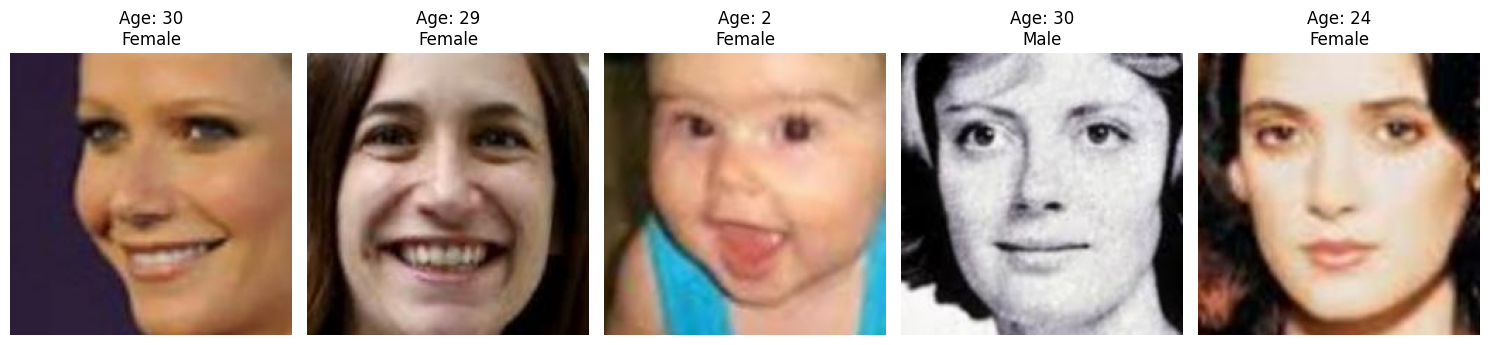

In [11]:
def plot_random_samples(df):
    # Select 5 random samples
    samples = df.sample(5)
    plt.figure(figsize=(15, 5))

    for i, (index, row) in enumerate(samples.iterrows()):
        # Get the path from the 'file' column
        img = cv2.imread(row['file'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)

        # Mapping gender for the title
        gender_label = "Male" if row['gender'] == 0 else "Female"
        plt.title(f"Age: {row['age']}\n{gender_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_random_samples(df)

Analyze label distributions(EDA)

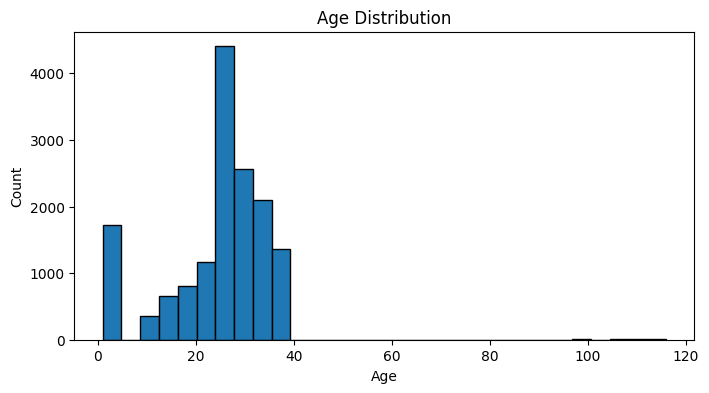

In [12]:
plt.figure(figsize=(8,4))
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

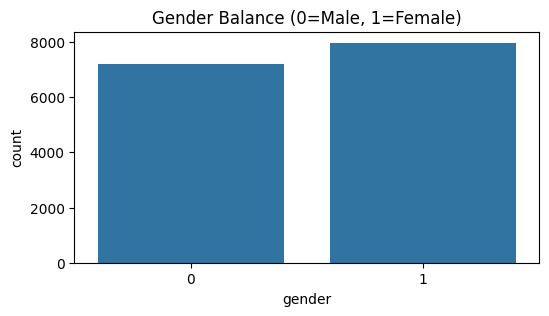

In [14]:
import seaborn as sns
plt.figure(figsize=(6,3))
sns.countplot(x='gender', data=df)
plt.title('Gender Balance (0=Male, 1=Female)')
plt.show()

In [15]:
df['gender'].value_counts()

,count
gender,
1,7968
0,7197


**Train-test split**

In [17]:
from sklearn.model_selection import train_test_split
train_df, val_df= train_test_split(df, test_size=0.2, random_state=42)

**Build tf.data pipeline**

In [19]:
IMG_SIZE=224
BATCH_SIZE=32
def preprocess_image(path, age, gender):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img, {"age": tf.cast(age, tf.float32), "gender": tf.cast(gender, tf.float32)}

**convert your Pandas DataFrames into TensorFlow datasets**

In [20]:
def create_dataset(dataframe, batch_size=32, shuffle=True):
    # Create a base dataset
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe['file'].values,
        dataframe['age'].values,
        dataframe['gender'].values
    ))

    # Shuffle (only for training)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))

    # Map the preprocessing function
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and Prefetch
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds

# Create actual dataset objects for training and validation
train_ds = create_dataset(train_df, shuffle=True)
val_ds = create_dataset(val_df, shuffle=False)

**Model Definition**

In [21]:
def build_model():
    base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),include_top=False,weights="imagenet")

    #Freeze the base model
    base_model.trainable = False
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    #Use training=False to keep BatchNormalization stable
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)

    #Dropout for better generalization
    x = tf.keras.layers.Dropout(0.5)(x)

    #Define Output Heads
    age_output = tf.keras.layers.Dense(1, name="age")(x)
    gender_output = tf.keras.layers.Dense(1, activation="sigmoid", name="gender")(x)

    #Return as a DICTIONARY to match tf.data pipeline
    model = tf.keras.Model(inputs=inputs, outputs={"age": age_output, "gender": gender_output})

    return model

model = build_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Compile Model**

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "age": "mae",
        "gender": "binary_crossentropy"
    },
    metrics={
        "age": "mae",
        "gender": "accuracy"
    }
)

**callbacks**

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Stop if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Lower learning rate if progress stalls
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Save the best model to a file
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Combine them into a list
my_callbacks = [early_stop, reduce_lr, checkpoint]

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 30,
    callbacks=my_callbacks
)

Epoch 1/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - age_loss: 8.2407 - age_mae: 8.2408 - gender_accuracy: 0.6480 - gender_loss: 0.9326 - loss: 9.1734

380/380 ━━━━━━━━━━━━━━━━━━━━ 2212s 6s/step - age_loss: 8.2370 - age_mae: 8.2371 - gender_accuracy: 0.6482 - gender_loss: 0.9321 - loss: 9.1692 - val_age_loss: 5.8220 - val_age_mae: 5.8222 - val_gender_accuracy: 0.7962 - val_gender_loss: 0.4198 - val_loss: 6.2422 - learning_rate: 0.0010
Epoch 2/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_loss: 6.0679 - age_mae: 6.0678 - gender_accuracy: 0.7633 - gender_loss: 0.5118 - loss: 6.5796

380/380 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - age_loss: 6.0678 - age_mae: 6.0677 - gender_accuracy: 0.7634 - gender_loss: 0.5117 - loss: 6.5795 - val_age_loss: 5.6161 - val_age_mae: 5.6155 - val_gender_accuracy: 0.8249 - val_gender_loss: 0.3738 - val_loss: 5.9895 - learning_rate: 0.0010
Epoch 3/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_loss: 5.8584 - age_mae: 5.8584 - gender_accuracy: 0.7942 - gender_loss: 0.4304 - loss: 6.2889

380/380 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - age_loss: 5.8584 - age_mae: 5.8585 - gender_accuracy: 0.7942 - gender_loss: 0.4305 - loss: 6.2889 - val_age_loss: 4.9297 - val_age_mae: 4.9302 - val_gender_accuracy: 0.8183 - val_gender_loss: 0.3760 - val_loss: 5.3063 - learning_rate: 0.0010
Epoch 4/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_loss: 5.8955 - age_mae: 5.8955 - gender_accuracy: 0.8025 - gender_loss: 0.4293 - loss: 6.3248

380/380 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - age_loss: 5.8954 - age_mae: 5.8954 - gender_accuracy: 0.8025 - gender_loss: 0.4293 - loss: 6.3247 - val_age_loss: 4.9095 - val_age_mae: 4.9098 - val_gender_accuracy: 0.8272 - val_gender_loss: 0.3753 - val_loss: 5.2852 - learning_rate: 0.0010
Epoch 5/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_loss: 5.6767 - age_mae: 5.6767 - gender_accuracy: 0.8022 - gender_loss: 0.4211 - loss: 6.0978

380/380 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - age_loss: 5.6769 - age_mae: 5.6769 - gender_accuracy: 0.8022 - gender_loss: 0.4211 - loss: 6.0980 - val_age_loss: 4.8716 - val_age_mae: 4.8726 - val_gender_accuracy: 0.8170 - val_gender_loss: 0.3754 - val_loss: 5.2481 - learning_rate: 0.0010
Epoch 6/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - age_loss: 5.6399 - age_mae: 5.6399 - gender_accuracy: 0.8029 - gender_loss: 0.4202 - loss: 6.0601 - val_age_loss: 4.9292 - val_age_mae: 4.9307 - val_gender_accuracy: 0.8282 - val_gender_loss: 0.3609 - val_loss: 5.2917 - learning_rate: 0.0010
Epoch 7/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - age_loss: 5.6326 - age_mae: 5.6326 - gender_accuracy: 0.8068 - gender_loss: 0.4134 - loss: 6.0461 - val_age_loss: 5.1409 - val_age_mae: 5.1411 - val_gender_accuracy: 0.8262 - val_gender_loss: 0.3646 - val_loss: 5.5057 - learning_rate: 0.0010
Epoch 8/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_loss: 5.4541 - age_mae: 5.4541 - gender_accuracy: 0.8057 - gend

380/380 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - age_loss: 5.4543 - age_mae: 5.4543 - gender_accuracy: 0.8057 - gender_loss: 0.4109 - loss: 5.8652 - val_age_loss: 4.8147 - val_age_mae: 4.8155 - val_gender_accuracy: 0.8216 - val_gender_loss: 0.3602 - val_loss: 5.1758 - learning_rate: 0.0010
Epoch 9/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - age_loss: 5.4246 - age_mae: 5.4246 - gender_accuracy: 0.8050 - gender_loss: 0.4075 - loss: 5.8321 - val_age_loss: 4.9023 - val_age_mae: 4.9029 - val_gender_accuracy: 0.8253 - val_gender_loss: 0.3655 - val_loss: 5.2687 - learning_rate: 0.0010
Epoch 10/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - age_loss: 5.5348 - age_mae: 5.5348 - gender_accuracy: 0.8122 - gender_loss: 0.4062 - loss: 5.9410 - val_age_loss: 4.8907 - val_age_mae: 4.8916 - val_gender_accuracy: 0.8286 - val_gender_loss: 0.3652 - val_loss: 5.2569 - learning_rate: 0.0010
Epoch 11/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - age_loss: 5.3758 - age_mae: 5.3758 - gender_accuracy: 0.8145 - 

380/380 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - age_loss: 5.3348 - age_mae: 5.3348 - gender_accuracy: 0.8244 - gender_loss: 0.3990 - loss: 5.7337 - val_age_loss: 4.7336 - val_age_mae: 4.7344 - val_gender_accuracy: 0.8266 - val_gender_loss: 0.3563 - val_loss: 5.0908 - learning_rate: 2.0000e-04
Epoch 13/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_loss: 5.3108 - age_mae: 5.3109 - gender_accuracy: 0.8316 - gender_loss: 0.3762 - loss: 5.6870

380/380 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - age_loss: 5.3108 - age_mae: 5.3108 - gender_accuracy: 0.8316 - gender_loss: 0.3762 - loss: 5.6870 - val_age_loss: 4.7287 - val_age_mae: 4.7298 - val_gender_accuracy: 0.8289 - val_gender_loss: 0.3537 - val_loss: 5.0836 - learning_rate: 2.0000e-04
Epoch 14/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - age_loss: 5.2186 - age_mae: 5.2186 - gender_accuracy: 0.8343 - gender_loss: 0.3744 - loss: 5.5930 - val_age_loss: 4.7731 - val_age_mae: 4.7744 - val_gender_accuracy: 0.8289 - val_gender_loss: 0.3516 - val_loss: 5.1261 - learning_rate: 2.0000e-04
Epoch 15/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_loss: 5.2811 - age_mae: 5.2811 - gender_accuracy: 0.8370 - gender_loss: 0.3741 - loss: 5.6552

380/380 ━━━━━━━━━━━━━━━━━━━━ 673s 2s/step - age_loss: 5.2811 - age_mae: 5.2811 - gender_accuracy: 0.8370 - gender_loss: 0.3741 - loss: 5.6552 - val_age_loss: 4.7246 - val_age_mae: 4.7253 - val_gender_accuracy: 0.8282 - val_gender_loss: 0.3528 - val_loss: 5.0782 - learning_rate: 2.0000e-04
Epoch 16/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - age_loss: 5.3005 - age_mae: 5.3005 - gender_accuracy: 0.8313 - gender_loss: 0.3724 - loss: 5.6729 - val_age_loss: 4.7343 - val_age_mae: 4.7350 - val_gender_accuracy: 0.8286 - val_gender_loss: 0.3546 - val_loss: 5.0898 - learning_rate: 2.0000e-04
Epoch 17/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - age_loss: 5.2635 - age_mae: 5.2635 - gender_accuracy: 0.8414 - gender_loss: 0.3671 - loss: 5.6306 - val_age_loss: 4.7336 - val_age_mae: 4.7345 - val_gender_accuracy: 0.8279 - val_gender_loss: 0.3523 - val_loss: 5.0870 - learning_rate: 2.0000e-04
Epoch 18/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_loss: 5.2141 - age_mae: 5.2141 - gender_accuracy

380/380 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - age_loss: 5.2141 - age_mae: 5.2142 - gender_accuracy: 0.8329 - gender_loss: 0.3774 - loss: 5.5916 - val_age_loss: 4.7242 - val_age_mae: 4.7248 - val_gender_accuracy: 0.8279 - val_gender_loss: 0.3519 - val_loss: 5.0770 - learning_rate: 2.0000e-04
Epoch 19/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - age_loss: 5.2956 - age_mae: 5.2956 - gender_accuracy: 0.8355 - gender_loss: 0.3714 - loss: 5.6670 - val_age_loss: 4.8679 - val_age_mae: 4.8683 - val_gender_accuracy: 0.8282 - val_gender_loss: 0.3520 - val_loss: 5.2205 - learning_rate: 2.0000e-04
Epoch 20/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - age_loss: 5.1888 - age_mae: 5.1888 - gender_accuracy: 0.8335 - gender_loss: 0.3745 - loss: 5.5633 - val_age_loss: 4.7395 - val_age_mae: 4.7406 - val_gender_accuracy: 0.8256 - val_gender_loss: 0.3538 - val_loss: 5.0945 - learning_rate: 2.0000e-04
Epoch 21/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - age_loss: 5.1160 - age_mae: 5.1160 - gender_accura

380/380 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - age_loss: 5.2774 - age_mae: 5.2773 - gender_accuracy: 0.8334 - gender_loss: 0.3751 - loss: 5.6525 - val_age_loss: 4.7093 - val_age_mae: 4.7101 - val_gender_accuracy: 0.8262 - val_gender_loss: 0.3510 - val_loss: 5.0612 - learning_rate: 4.0000e-05
Epoch 23/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 678s 2s/step - age_loss: 5.2122 - age_mae: 5.2123 - gender_accuracy: 0.8393 - gender_loss: 0.3690 - loss: 5.5812 - val_age_loss: 4.7219 - val_age_mae: 4.7225 - val_gender_accuracy: 0.8276 - val_gender_loss: 0.3518 - val_loss: 5.0745 - learning_rate: 4.0000e-05
Epoch 24/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - age_loss: 5.1923 - age_mae: 5.1923 - gender_accuracy: 0.8307 - gender_loss: 0.3809 - loss: 5.5732 - val_age_loss: 4.7154 - val_age_mae: 4.7161 - val_gender_accuracy: 0.8272 - val_gender_loss: 0.3512 - val_loss: 5.0675 - learning_rate: 4.0000e-05
Epoch 25/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - age_loss: 5.1748 - age_mae: 5.1749 - gender_accura

In [27]:
results = model.evaluate(val_ds)

95/95 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - age_loss: 4.7027 - age_mae: 4.7027 - gender_accuracy: 0.8204 - gender_loss: 0.3530 - loss: 5.0557


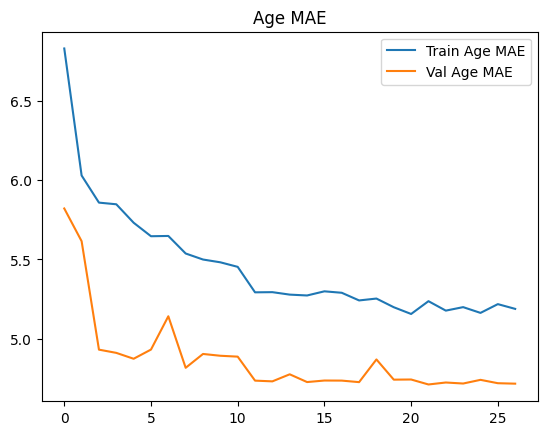

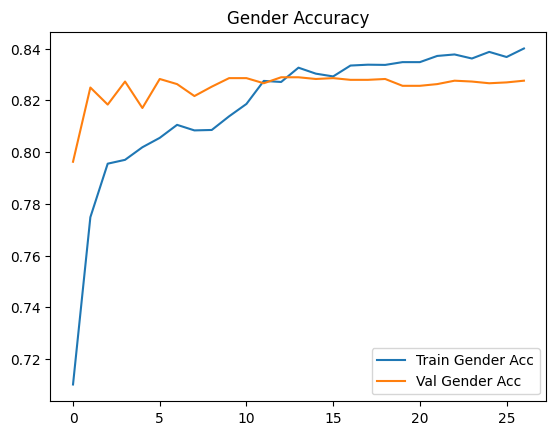

In [28]:
# Age MAE
plt.plot(history.history['age_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_mae'], label='Val Age MAE')
plt.legend()
plt.title('Age MAE')
plt.show()

# Gender Accuracy
plt.plot(history.history['gender_accuracy'], label='Train Gender Acc')
plt.plot(history.history['val_gender_accuracy'], label='Val Gender Acc')
plt.legend()
plt.title('Gender Accuracy')
plt.show()
